# Time series Forecasting with XGBoost and LightGBM
https://medium.com/@geokam/time-series-forecasting-with-xgboost-and-lightgbm-predicting-energy-consumption-460b675a9cee

In [47]:
%pip install --upgrade --quiet  xgboost lightgbm statsmodels seaborn

Note: you may need to restart the kernel to use updated packages.


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
# import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# lag features imports
from matplotlib.offsetbox import AnchoredText
from statsmodels.graphics.tsaplots import plot_pacf
import seaborn as sns
import math

In [13]:
df = pd.read_csv("/Users/leoung/Documents/Models/london_energy.csv")  #  https://www.kaggle.com/datasets/emmanuelfwerr/london-homes-energy-data
print(df.isna().sum())
df.head()

LCLid    0
Date     0
KWH      0
dtype: int64


,LCLid,Date,KWH
0,MAC000002,2012-10-12,7.098
1,MAC000002,2012-10-13,11.087
2,MAC000002,2012-10-14,13.223
3,MAC000002,2012-10-15,10.257
4,MAC000002,2012-10-16,9.769


In [32]:
len(df)

3510433

In [33]:
df_avg_consumption = df.groupby("Date")["KWH"].mean()
df_avg_consumption = pd.DataFrame({"date": df_avg_consumption.index.tolist(), "consumption": df_avg_consumption.values.tolist()})
df_avg_consumption["date"] = pd.to_datetime(df_avg_consumption["date"])
print(f"From: {df_avg_consumption['date'].min()}")
print(f"To: {df_avg_consumption['date'].max()}")

From: 2011-11-23 00:00:00
To: 2014-02-28 00:00:00


In [34]:
len(df_avg_consumption)

829

In [35]:
df_avg_consumption = df.groupby("Date")["KWH"].mean()
df_avg_consumption = pd.DataFrame({"date": df_avg_consumption.index.tolist(), "consumption": df_avg_consumption.values.tolist()})
df_avg_consumption["date"] = pd.to_datetime(df_avg_consumption["date"])
print(f"From: {df_avg_consumption['date'].min()}")
print(f"To: {df_avg_consumption['date'].max()}")

From: 2011-11-23 00:00:00
To: 2014-02-28 00:00:00


<AxesSubplot:xlabel='date'>

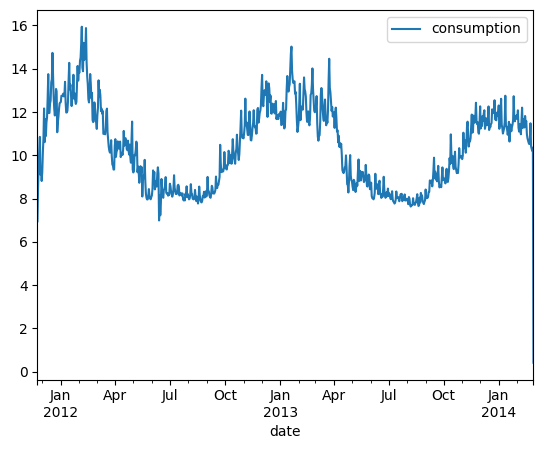

In [36]:
df_avg_consumption.plot(x="date", y="consumption")

## Features Engineering

In [37]:
df_avg_consumption["day_of_week"] = df_avg_consumption["date"].dt.dayofweek
df_avg_consumption["day_of_year"] = df_avg_consumption["date"].dt.dayofyear
df_avg_consumption["month"] = df_avg_consumption["date"].dt.month
df_avg_consumption["quarter"] = df_avg_consumption["date"].dt.quarter
df_avg_consumption["year"] = df_avg_consumption["date"].dt.year

df_avg_consumption.head()

,date,consumption,day_of_week,day_of_year,month,quarter,year
0,2011-11-23,6.952692,2,327,11,4,2011
1,2011-11-24,8.536480,3,328,11,4,2011
2,2011-11-25,9.499781,4,329,11,4,2011
3,2011-11-26,10.267707,5,330,11,4,2011
4,2011-11-27,10.850805,6,331,11,4,2011


## train/test

(613, 19)
(216, 19)


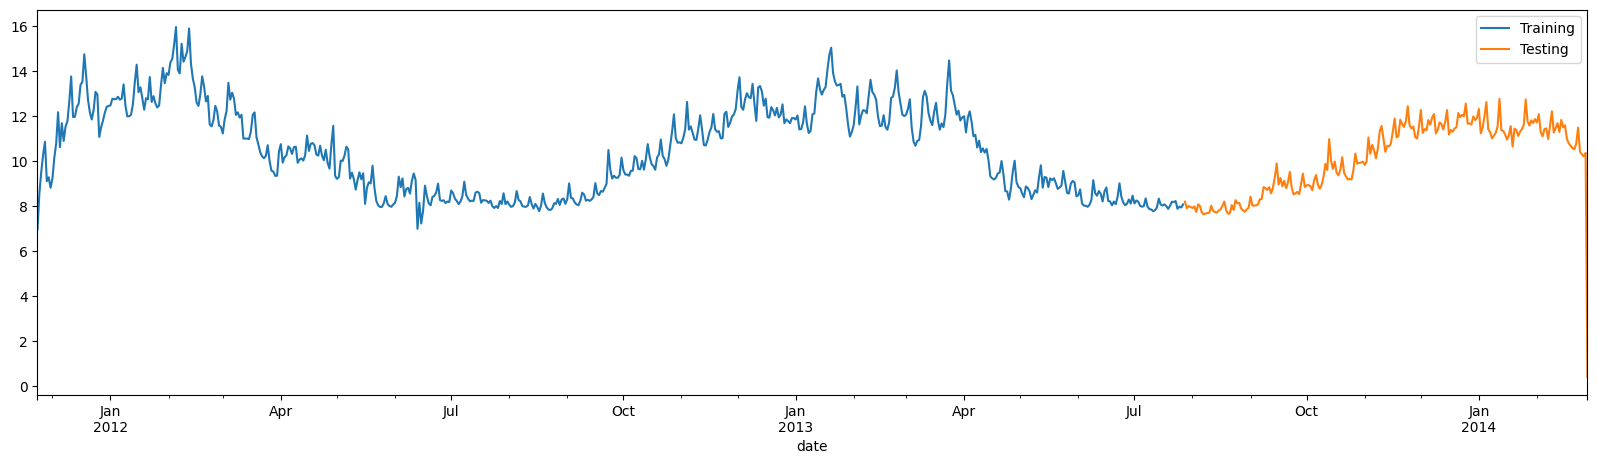

In [63]:
training_mask = df_avg_consumption["date"] < "2013-07-28"
training_data = df_avg_consumption.loc[training_mask]
print(training_data.shape)

testing_mask = df_avg_consumption["date"] >= "2013-07-28"
testing_data = df_avg_consumption.loc[testing_mask]
print(testing_data.shape)


figure, ax = plt.subplots(figsize=(20, 5))
training_data.plot(ax=ax, label="Training", x="date", y="consumption")
testing_data.plot(ax=ax, label="Testing", x="date", y="consumption")
plt.show()

In [64]:
# Dropping unnecessary `date` column
training_data = training_data.drop(columns=["date"])
testing_dates = testing_data["date"]
testing_data = testing_data.drop(columns=["date"])

X_train = training_data[['day_of_week', 'day_of_year', 'month', 'quarter', 'year',
       'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'lag_9', 'lag_10', 'lag_11', 'lag_12']]
y_train = training_data["consumption"]

X_test = testing_data[['day_of_week', 'day_of_year', 'month', 'quarter', 'year',
       'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'lag_9', 'lag_10', 'lag_11', 'lag_12']]
y_test = testing_data["consumption"]

In [61]:
training_data.columns

Index(['consumption', 'day_of_week', 'day_of_year', 'month', 'quarter', 'year',
       'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'lag_9', 'lag_10', 'lag_11', 'lag_12'],
      dtype='object')

## training the model

In [65]:
# from xgboost import XGBRegressor
# import lightgbm as lgb
# from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# XGBoost
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = XGBRegressor()
parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impo...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 6, 5, 10],
                         'n_estimators': [100, 300, 500, 700, 900, 1000]})

In [ ]:
# evaluation

In [41]:

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,\
  mean_squared_error

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")

def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Prediction"])
  plt.show()

,day_of_week,day_of_year,month,quarter,year
613,6,209,7,3,2013
614,0,210,7,3,2013
615,1,211,7,3,2013
616,2,212,7,3,2013
617,3,213,8,3,2013
...,...,...,...,...,...
824,0,55,2,1,2014
825,1,56,2,1,2014
826,2,57,2,1,2014
827,3,58,2,1,2014


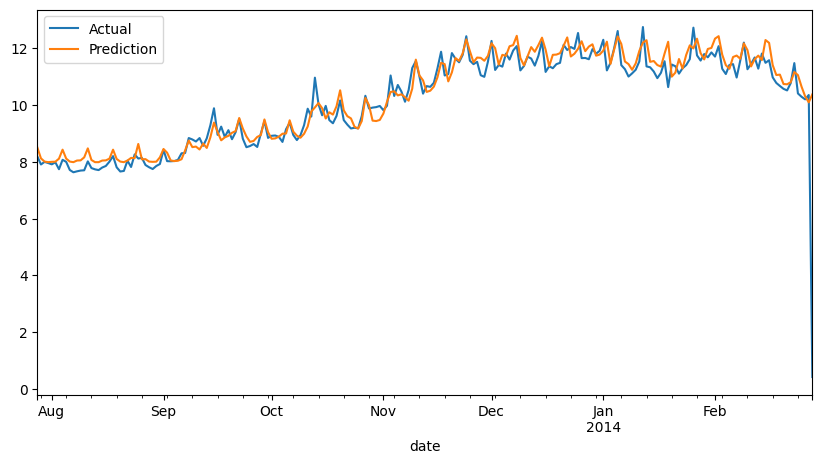

MAE: 0.33091955181051236
MSE: 0.5916635963996462
MAPE: 0.1381905538125909


In [66]:
# Evaluating GridSearch results
prediction = grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)

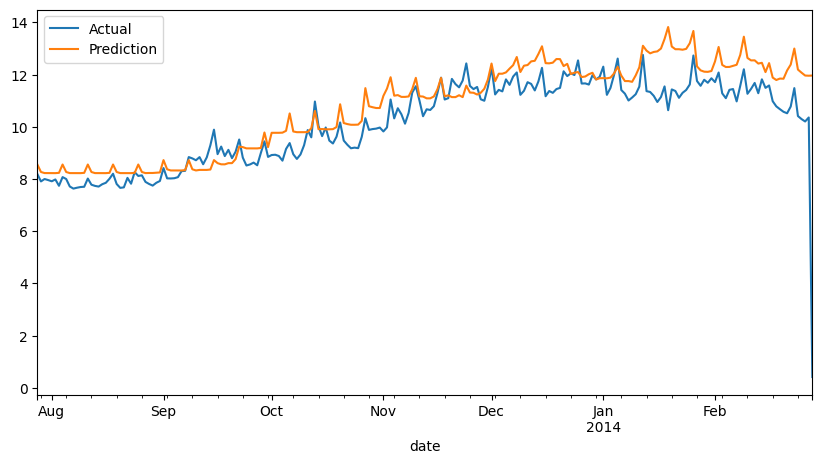

MAE: 0.726046583678707
MSE: 1.3039994731161895
MAPE: 0.19346012873545185


In [57]:
# Evaluating GridSearch results
prediction = grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)

## Lag features

In [49]:
def plot_lag(x, lag=1, ax=None, **kwargs):
    x_ = x.shift(lag)
    y_ = x
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line = dict(color='C3', )

    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    
    # Adding correlation on plot
    at = AnchoredText(
        f"{y_.corr(x_):.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_autocorrelation(x, lags=6, lagplot_kwargs={}, **kwargs):
    kwargs.setdefault("nrows", 2)
    kwargs.setdefault("ncols", math.ceil(lags / 2))
    kwargs.setdefault("figsize", (kwargs["ncols"] * 2, 2  * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(2 * kwargs["ncols"])):
        if k + 1 <= lags:
            ax = plot_lag(x, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag #{k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis("off")
    plt.setp(axs[-1, :], xlabel=x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

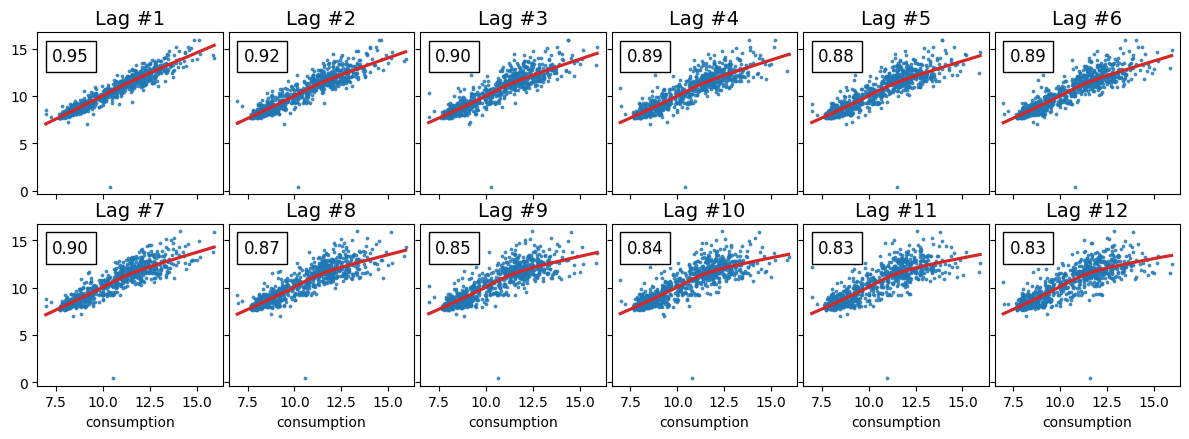

In [50]:
_ = plot_autocorrelation(df_avg_consumption["consumption"], lags=12)

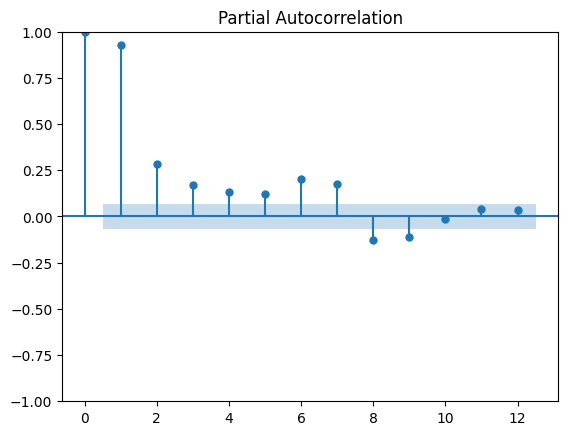

In [51]:
_ = plot_pacf(df_avg_consumption["consumption"], lags=12)

3 

### We can clearly see that the first 9 lags possibly contain valuable information since they’re out of the bluish area. This area is related to the confidence interval that was chosen in the `plot_pacf` function, with the default value being 95%.

In [53]:

def create_lag_features(df, lags=2):
  y = df_avg_consumption.loc[:, "consumption"]
  for lag in range(lags):
    df[f"lag_{lag + 1}"] = y.shift(lag + 1)
  return df

df_avg_consumption = create_lag_features(df_avg_consumption, lags=12)
df_avg_consumption.head(4)

,date,consumption,day_of_week,day_of_year,month,quarter,year,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2011-11-23,6.952692,2,327,11,4,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-11-24,8.536480,3,328,11,4,2011,6.952692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-11-25,9.499781,4,329,11,4,2011,8.536480,6.952692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-11-26,10.267707,5,330,11,4,2011,9.499781,8.536480,6.952692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
